# Bird species image classification

В классификации участвовало N видов птиц, обитающих в Европейской части России.
Датасет был собран по латинским названиям из Google imgs

In [1]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=5e46faabe9f8deeee0a3a51d8d5414d24e2b38bc7eca2a6930b9c5c683b5e423
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import torchvision.transforms as T
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler
import PIL
from pathlib import Path
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
from datetime import date
import random

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
os.mkdir("/content/bird_dataset")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


В задаче классификации участвовали фотографии 350 классов (фотографии были собраны из google images по английским названиям.

In [7]:
BATCH_SIZE = 50
EPOCHES = 3
lr=1e-5
IMG_SIZE = [256, 256]
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# 1 Classification

## 1.1 Dataset & dataloader

Фотографии находятся в архиве в папках по классам без разделения на тестовую и обучающую выборки.

In [8]:
%%bash
tar -xvf '/content/drive/MyDrive/bird_species/bird-dataset.tar.gz' -C ./bird_dataset

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
img_path = './bird_dataset/dataset' # путь до папки с датасетом

In [10]:
labels = sorted(os.listdir(img_path))
label_dict = {i:labels[i] for i in range(0, len(labels))}
num_classes = len(label_dict)

In [11]:
print('N classes:', num_classes)

N classes: 350


In [12]:
# # finding broken files
# folders = os.listdir(img_path)
# folders_loop = tqdm(folders[:100], position=0, leave=True)
# for folder in folders_loop:
#   for img in os.listdir(os.path.join(img_path, folder)):
    
#     try:
#       origin = PIL.Image.open(os.path.join(img_path, folder, img))
#     except PIL.UnidentifiedImageError:
#       print('cannot identify image file:', img, folder)
#       os.remove(os.path.join(img_path, folder, img))
# folders_loop.close()

### 1.1.1 Augmentation

In [13]:
def transform(image, img_size, split):
    # different transformations for 'train' or 'test' splits
    assert split in {'TRAIN', 'TEST'}

    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    new_image = image

    if split == 'TRAIN':
        img_blurrer = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
        img_autocontrast = T.RandomAutocontrast(p=0.5)
        rotate = T.RandomRotation(degrees=(0, 90))
        sharpness_adjuster = T.RandomAdjustSharpness(sharpness_factor=2)
        hflip = T.RandomHorizontalFlip(p=0.5)

        new_image = hflip(new_image)

        if random.random() < 0.4:
            new_image = img_blurrer(new_image)
            new_image = img_autocontrast(new_image)
        if random.random() < 0.3:
            new_image = sharpness_adjuster(new_image)
            new_image = rotate(new_image)
            
    base_transform = T.Compose([T.ToTensor(), 
                                T.Resize(img_size), 
                                T.Normalize(mean=mean, std=std)])
    new_image = base_transform(new_image)  

    return new_image
     

In [14]:
class BirdDataset(Dataset):
    def __init__(self, img_folder, img_size, split):
        super().__init__()
        self.img_folder = img_folder
        self.img_size = img_size
        self.split = split.upper()
        assert self.split in {'TRAIN', 'TEST'}
     
        self.dataset = datasets.ImageFolder(self.img_folder, transform=None)

    def __len__(self):
        return len(self.dataset)
  
    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        if image.mode != 'RGB':
            image = image.convert('RGB')  
        image = transform(image, self.img_size, self.split)
        object_label = self.dataset[idx][1]

        return {'image': image, 'label': object_label}

In [15]:
bird_set = BirdDataset(img_path, IMG_SIZE, split='train')

In [16]:
def draw_label(label, is_pred=False):
    class_labels = labels
    class_lb = label_dict[label]
    if is_pred:
        colormap = "tab20b"
        V = 'bottom'
    else:
        colormap = "tab20c"
        V = 'top'
    cmap = plt.get_cmap(colormap)
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    text_params = ({'horizontalalignment':'left',
                   'verticalalignment':V,
                   'color':"white",
                   'bbox':{"color": colors[int(label)], 
                           "pad": 0}})
    
    return class_lb, text_params

In [17]:
def show_img_n_lbl(data_set, is_labels_pred=False):
    f, axes = plt.subplots(2,5, figsize=(14, 6))
    for i in range(2):
        for p in range(5):
            idx = np.random.randint(0, len(data_set))
            img_tensor = data_set[idx]['image']
            label = data_set[idx]['label']
            image = np.moveaxis(img_tensor.numpy(), 0, 2)
            image = image * np.array(std) + np.array(mean)
            
            if is_labels_pred:
                with torch.no_grad():
                    label_pred = model(torch.unsqueeze(img_tensor, dim=0).to(device)).cpu().numpy()[0].argmax()
                                
                class_pred, pred_params = draw_label(label_pred, is_pred=True)
                axes[i][p].text(0, 0, 'pred:'+class_pred ,pred_params)
         
            axes[i][p].axis('off')
            axes[i][p].imshow(image.clip(0, 1))
            class_gt, params = draw_label(label, is_pred=False)
            axes[i][p].text(0, 0, 'gt:'+class_gt, params)


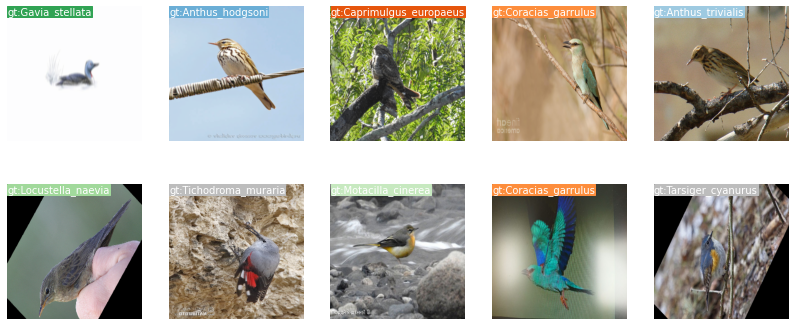

In [18]:
show_img_n_lbl(bird_set, is_labels_pred=False)

### 1.1.2 Train & val split 

In [19]:
# train/val split 
train_size = int(0.8 * len(bird_set))
val_size = len(bird_set) - train_size
train_set, val_set = torch.utils.data.random_split(bird_set, 
                                                    [train_size, val_size], 
                                                    generator=torch.Generator().manual_seed(42))

In [20]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## 1.2 Network architecture

В качестве модели использовалась предобученная [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf)

После каждой эпохи параметры модели сохранялись в файл и подгружались в модель после каждых 5-и эпох. Это было сделано для преодоления ограничений colab.

In [21]:
checkpoints_filepath = "/content/drive/MyDrive/bird_species/checkpoints"

In [22]:
def save_checkpoint(model, optimizer, filepath=checkpoints_filepath):
    # make checkpoint dir 
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    filepath = Path(filepath)
    checkpoint = {'state_dict': model.state_dict(),
                  'optimizer': optimizer.state_dict()}
    today = date.today()
    filename = "my_checkpoint" + str(today) + ".pth.tar"
    print('Saving checkpoint', filename)
    torch.save(checkpoint, filepath/filename)

In [23]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("Loading checkpoint", checkpoint_file)
    filepath=Path(checkpoints_filepath)
    checkpoint = torch.load(filepath / checkpoint_file)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EfficientNet.from_name('efficientnet-b0')
model.load_state_dict(torch.load('/content/drive/MyDrive/bird_species/efficientnet-b0-08094119.pth'))   # from https://www.kaggle.com/hmendonca/efficientnet-pytorch
# for param in model.parameters():
#     param.requires_grad = False
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)
model = model.to(device)

In [25]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

In [26]:
load_checkpoint('my_checkpoint2021-11-23.pth.tar', model, optimizer, lr)

Loading checkpoint my_checkpoint2021-11-23.pth.tar


## 1.3 Model training

In [27]:
def model_train(train_loader, model, optimizer, loss_fn):
    model.train()
    epoch_loss = 0.
    correct = 0
    total = 0
    train_loop = tqdm(train_loader, position=0, leave=True)
    for batch_idx, batch in enumerate(train_loop):
        images, labels = batch['image'], batch['label']
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(images)
        correct += (labels == predictions.argmax(dim=1,)).sum()
        total += len(labels)

        loss = loss_fn(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        mean_loss = epoch_loss / len(train_loader)
        train_loop.set_postfix({'train_loss':mean_loss}, refresh=True)
    train_loop.close()
    accuracy = correct / total
    print(f"Train accuracy is: {accuracy*100:2f}%")
    return epoch_loss

def val_model(val_loader, model, optimizer, loss_fn):
    model.eval()
    epoch_loss = 0.
    correct = 0
    total = 0
    val_loop = tqdm(val_loader, position=0, leave=True)
    for batch_idx, batch in enumerate(val_loop):
        images, labels = batch['image'], batch['label']
        images = images.to(device)
        labels = labels.to(device)

        predictions = model(images)
        correct += sum((labels == predictions.argmax(dim=1,)))
        total += len(labels)
        with torch.no_grad():
            loss = loss_function(predictions, labels)

        epoch_loss += loss.item()
        mean_loss = epoch_loss / len(val_loader)
        
        val_loop.set_postfix({'val_loss':mean_loss}, refresh=True)
    val_loop.close()
    accuracy = correct / total
    print(f"Val accuracy is: {accuracy*100:2f}%")
    return epoch_loss


In [28]:
# train_loss_per_epoche = []
# val_loss_per_epoche = []

In [29]:
for epoch in range(EPOCHES):
    print('Epoch {}/{}'.format(epoch + 1, EPOCHES))

    train_loss = model_train(train_loader, model, optimizer, loss_function)
    save_checkpoint(model, optimizer, filepath=checkpoints_filepath)
    val_loss = val_model(val_loader, model, optimizer, loss_function)
    with open('/content/drive/MyDrive/bird_species/loss.txt', 'a') as w:
        w.write(str(train_loss)+' '+str(val_loss)+'\n')

    # train_loss_per_epoche.append(train_loss)
    # val_loss_per_epoche.append(val_loss)

Epoch 1/3


100%|██████████| 1851/1851 [53:06<00:00,  1.72s/it, train_loss=0.665]


Train accuracy is: 82.559685%
Saving checkpoint my_checkpoint2021-11-24.pth.tar


100%|██████████| 463/463 [14:35<00:00,  1.89s/it, val_loss=0.693]


Val accuracy is: 81.350510%
Epoch 2/3


100%|██████████| 1851/1851 [56:48<00:00,  1.84s/it, train_loss=0.649]


Train accuracy is: 82.988754%
Saving checkpoint my_checkpoint2021-11-24.pth.tar


100%|██████████| 463/463 [17:03<00:00,  2.21s/it, val_loss=0.685]


Val accuracy is: 81.696350%
Epoch 3/3


100%|██████████| 1851/1851 [56:12<00:00,  1.82s/it, train_loss=0.635]


Train accuracy is: 83.429703%
Saving checkpoint my_checkpoint2021-11-24.pth.tar


100%|██████████| 463/463 [17:17<00:00,  2.24s/it, val_loss=0.68]


Val accuracy is: 81.644478%


In [30]:
save_checkpoint(model, optimizer, filepath=checkpoints_filepath)

Saving checkpoint my_checkpoint2021-11-24.pth.tar


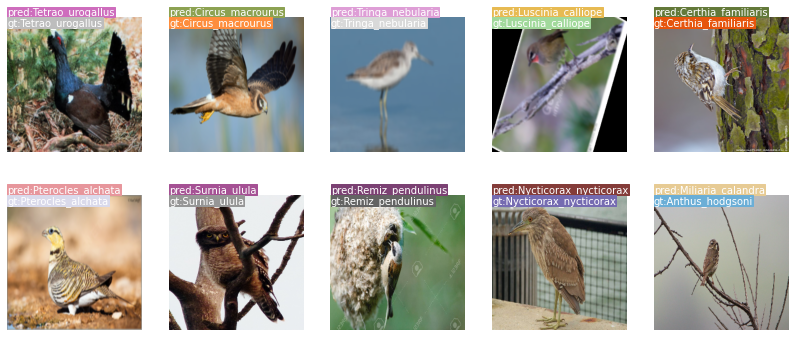

In [31]:
show_img_n_lbl(val_set, is_labels_pred=True)

In [32]:
loss_path = '/content/drive/MyDrive/bird_species/loss.txt'
train_loss_per_epoche = []
val_loss_per_epoche = []
with open(loss_path, 'r') as rf:
    for losses in rf:
        losses = losses.split()
        train_loss_per_epoche.append(float(losses[0])/1851)
        val_loss_per_epoche.append(float(losses[1])/463)


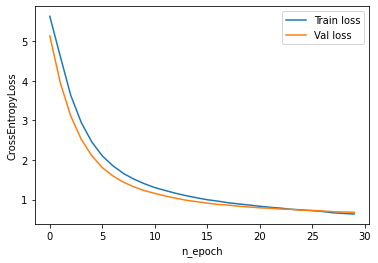

In [33]:
fig, ax = plt.subplots()

n_epoch = range(len(train_loss_per_epoche))
ax.plot(n_epoch, train_loss_per_epoche, label="Train loss")
ax.plot(n_epoch, val_loss_per_epoche, label="Val loss")
ax.set_xlabel('n_epoch')
ax.set_ylabel('CrossEntropyLoss')
ax.legend()

plt.show()

По графику видно, что сеть начала переобучаться на 25-ой эпохе. 